Simple test of app/pipeline.py in jupyter notebook.
This file made use of functions from app/pipeline.py, but I did a slight modifications. 
Most importantly, I often deleted "self" or "self." from the functions.

# Where should this jupyter notebook located?

In [1]:
%pwd

'/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion'

In [2]:
%ls -l

total 51040
drwxr-xr-x  15 kohei  staff      480 Jan 11 04:07 -mksamplefits_old/
-rw-r--r--   1 kohei  staff     1066 Jan  7 22:13 Dockerfile.build
-rw-r--r--   1 kohei  staff     3059 Jan  7 22:13 Jenkinsfile
-rw-r--r--   1 kohei  staff    13671 Jan  7 22:12 MANUAL.md
-rw-r--r--   1 kohei  staff     7272 Jan  7 22:13 README.md
-rw-r--r--   1 kohei  staff     1260 Jan  7 22:12 REFURBISHMENT.md
drwxr-xr-x  16 kohei  staff      512 Jan 13 15:19 app/
drwxr-xr-x  11 kohei  staff      352 Jan  7 22:13 common/
drwxr-xr-x   5 kohei  staff      160 Jan  7 22:12 config/
drwxr-xr-x   4 kohei  staff      128 Jan  7 22:13 doc/
drwxr-xr-x   7 kohei  staff      224 Jan 11 21:18 estimation/
drwxr-xr-x   8 kohei  staff      256 Jan 13 10:07 image/
drwxr-xr-x  16 kohei  staff      512 Jan 11 23:13 mksamplefits/
drwxr-xr-x  13 kohei  staff      416 Jan 11 23:28 mksamplefits2_static/
drwxr-xr-x  12 kohei  staff      384 Jan 12 05:48 mksamplefits3_single_star/
drwxr-xr-x   6 kohei  staff      192 Jan  7 2

In [3]:
%ls -l app/

total 200
-rw-r--r--  1 kohei  staff      0 Jan  7 22:13 __init__.py
drwxr-xr-x  7 kohei  staff    224 Jan 12 06:12 __pycache__/
-rw-r--r--@ 1 kohei  staff  15553 Jan 11 22:40 calculate_center_position.py
-rw-r--r--@ 1 kohei  staff   1393 Jan  7 22:13 calculate_star_position.py
-rw-r--r--  1 kohei  staff   6189 Jan  7 22:13 generate_image_data.py
-rw-r--r--  1 kohei  staff   4110 Jan  7 22:13 generate_star_center.py
-rw-r--r--@ 1 kohei  staff    519 Jan  7 22:13 pipeline.json
-rw-r--r--@ 1 kohei  staff  36919 Jan 11 23:12 pipeline.py
-rw-r--r--@ 1 kohei  staff    608 Jan 11 23:01 pipeline_stellar_motion_1.json
-rw-r--r--@ 1 kohei  staff    624 Jan 11 23:18 pipeline_stellar_motion_2_static.json
-rw-r--r--@ 1 kohei  staff    634 Jan 12 05:57 pipeline_stellar_motion_3.json
-rw-r--r--@ 1 kohei  staff    630 Jan 13 15:19 pipeline_stellar_motion_4.json
-rw-r--r--  1 kohei  staff   1251 Jan  7 22:13 reverse_calculation_of_psf.py


In [4]:
import argparse
import csv
import importlib
import pathlib
import sys
import os
import json

#sys.path.append('../../')#kohei
sys.path.append('../')#kohei
#sys.path.append(str(pathlib.Path(__file__).resolve().parent) + '/../')

from config.module import np_module
from common.logger import Logger
from common.listutil import ListUtil
from app.calculate_center_position import CenterCalculator
from image.large_frame_processor import LargeFrameProcessor
from image.distortion import MappedStarObservationsOnPlate, DistortionCalculator, DistortionParameters
from estimation.position import MappedStarObservations, PositionEstimation

np = importlib.import_module(np_module)

logger = Logger(__name__)

#kohei
import sys
from inspect import currentframe, getframeinfo
frameinfo = getframeinfo(currentframe())
#print(frameinfo.filename, frameinfo.lineno)


/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/estimation/psf.py 10


In [5]:
from matplotlib import pyplot

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Read json file

In [6]:
f = open('/Users/kohei/JASMINE/from_kyoto/analysis_sandbox_kohei_distortion/app/pipeline_stellar_motion_3.json')

In [7]:
%cat app/pipeline_stellar_motion_3.json

{
    "framecsvpath": "mksamplefits3_single_star/dataset/frames.csv",
    "outputdir": "outputdir_stellar_motion_3",
    "brighterthreshold": 20000,
    "darkerthreshold": 16000,
    "dpixel": 2.6E-06,
    "starimagesize": 9,
    "centeriteration": 20,
    "positioniteration": 20,
    "lighterstarsamerange": 20.0,
    "darkerstarsamerange": 4.0,
    "largeframesamerange": 4.0,
    "positiontosolve": 2,
    "xmagnification": 3,
    "ymagnification": 3,
    "knownstarspath": "mksamplefits3_single_star/dataset/known_stars.csv", "knownstarsneighborhood": 10.0,
    "plateparameterdimension": 5,
    "psfbrightnessthreshold": 2000
}


In [8]:
json_data = json.load(f)

In [9]:
frame_csv_path=json_data['framecsvpath']
output_directory=json_data['outputdir']
brighter_threshold=json_data['brighterthreshold']
darker_threshold=json_data['darkerthreshold']
dpixel=json_data['dpixel']
star_image_size=json_data['starimagesize']
lighter_star_same_range=json_data['lighterstarsamerange']
darker_star_same_range=json_data['darkerstarsamerange']
large_frame_same_range=json_data['largeframesamerange']
center_iteration=json_data['centeriteration']
x_magnification=json_data['xmagnification']
y_magnification=json_data['ymagnification']
position_to_solve=json_data['positiontosolve']
position_iteration=json_data['positioniteration']
known_stars_path=json_data['knownstarspath']
known_stars_neighborhood=json_data['knownstarsneighborhood']
plate_parameter_dimension=json_data['plateparameterdimension']
psf_brightness_threshold=json_data['psfbrightnessthreshold']

In [10]:
lighter_star_same_ecliptic_range = lighter_star_same_range * dpixel
known_stars_ecliptic_neighborhood = known_stars_neighborhood * dpixel
darker_star_same_ecliptic_range = darker_star_same_range * dpixel




In [11]:

class LargeFrameInfo:
    """
    Large frame information.
    """

    def __init__(self, csv_rows, csv_dir):
        """
        Initialize object.

        Parameters
        ----------
        csv_rows: list
            List of CSV rows
        csv_dir: str
            CSV file path
        """
        self.__directory = pathlib.Path(csv_dir).parent.joinpath(csv_rows[0])
        self.__time = float(csv_rows[1])
        self.__longitude = float(csv_rows[2])

    @property
    def directory(self):
        return str(self.__directory)

    @property
    def time(self):
        return self.__time

    @property
    def longitude(self):
        return self.__longitude

    def get_star_center_file_name(self):
        return 'center_' + self.__directory.resolve().name + '.csv'

    def get_plate_parameter_file_name(self):
        return 'plate_' + self.__directory.resolve().name + '.csv'

In [12]:
def __parse_frame_csv():
    """
    Load large frame information file.

    Returns
    -------
    large_frame_info_list: list
        List of LargeFrameInfo
    """
    with open(frame_csv_path) as fr:
        reader = csv.reader(fr)
        next(reader)
        return [LargeFrameInfo(r, frame_csv_path) for r in reader]
large_frame_info_list = __parse_frame_csv()

In [13]:
def __parse_known_stars_csv():
    """
    Parse known stars CSV file.

    Returns
    -------
    known_stars: np.array (2 order)
        List of (star id ( = -1), lambda, beta, mu lambda, mu beta, pi)
    """
    if os.path.exists(known_stars_path):
        with open(known_stars_path) as fr:
            reader = csv.reader(fr)
            next(reader)
            # element is (star id, lambda, beta, mu lambda, mu beta, pi)
            # -1 of star id means not mapped
            return np.array([[-1, float(r[0]), float(r[1]), float(r[2]), float(r[3]), float(r[4])] for r in reader])

    logger.warn('Known stars position file %s is not found.', known_stars_path[0])
    return np.array([])

known_star_params=__parse_known_stars_csv()

In [14]:

# parse each large frame
plate_id_offset = 1
all_star_data = []
star_id_lambda_beta_list = []
time_list = []
plate_data_list = []
c_plate_parameter_list = []
d_plate_parameter_list = []

In [15]:
for large_frame_info in large_frame_info_list:
    large_frame_info.directory
    print(large_frame_info.directory)
    print(large_frame_info.get_star_center_file_name())
    print(large_frame_info.get_plate_parameter_file_name())
    print(plate_id_offset)
    print(known_star_params)
    print(psf_brightness_threshold)

mksamplefits3_single_star/dataset/frame00000
center_frame00000.csv
plate_frame00000.csv
1
[[-1.00000000e+00  4.64687383e+00 -9.55758431e-02  3.85391903e-05
   3.52756613e-05  3.65979487e-05]
 [-1.00000000e+00  4.65138149e+00 -9.01716796e-02  2.66450707e-05
   4.00768546e-06  2.27972941e-05]
 [-1.00000000e+00  4.64534257e+00 -8.80898088e-02  4.73539003e-05
   1.67675388e-05  1.54702965e-05]
 ...
 [-1.00000000e+00  4.64875331e+00 -9.97288602e-02  2.85312099e-05
   9.04468392e-06  4.98054343e-05]
 [-1.00000000e+00  4.64483656e+00 -9.57740472e-02  1.04299233e-05
   9.43017529e-06  4.07493527e-05]
 [-1.00000000e+00  4.65750332e+00 -1.02507554e-01  2.07930334e-05
   3.95266103e-05  4.28359871e-05]]
2000
mksamplefits3_single_star/dataset/frame00001
center_frame00001.csv
plate_frame00001.csv
1
[[-1.00000000e+00  4.64687383e+00 -9.55758431e-02  3.85391903e-05
   3.52756613e-05  3.65979487e-05]
 [-1.00000000e+00  4.65138149e+00 -9.01716796e-02  2.66450707e-05
   4.00768546e-06  2.27972941e-05]
 

In [16]:
def estimate_center_from_one_large_frame(directory, output_center_csv_name, output_plate_csv_name, plate_id_offset, known_star_params, psf_brightness_threshold):
    
    large_frame_processor = LargeFrameProcessor(
            plate_id_offset=plate_id_offset,
            directory=directory,
            dpixel=dpixel,
            star_image_size=star_image_size
    )
    print(psf_brightness_threshold)
    

    center_calculator = CenterCalculator(
        center_iteration=center_iteration[0],
        x_magnification=x_magnification[0],
        y_magnification=y_magnification[0],
        max_iteration=center_iteration[0],
        psf_brightness_threshold=psf_brightness_threshold
    )
    print(lighter_star_same_ecliptic_range)
    print(brighter_threshold[0])
    
    brighter_star_position_in_pixel, extracted_brighter_star_image_list = \
    large_frame_processor.execute(
            same_star_ecliptic_range=lighter_star_same_ecliptic_range,
            binary_threshold=brighter_threshold
    )
    
    return \
    brighter_star_position_in_pixel, \
    extracted_brighter_star_image_list

# Have a detailed look at the first element of large_frame_info_list

In [17]:
large_frame_info = large_frame_info_list[0]

In [18]:
large_frame_info.directory

'mksamplefits3_single_star/dataset/frame00000'

In [19]:
directory, output_center_csv_name, output_plate_csv_name, plate_id_offset, known_star_params, psf_brightness_threshold = \
large_frame_info.directory, \
large_frame_info.get_star_center_file_name(), \
large_frame_info.get_plate_parameter_file_name(), \
plate_id_offset, \
known_star_params, \
psf_brightness_threshold
    
large_frame_processor = LargeFrameProcessor(
            plate_id_offset=plate_id_offset,
            directory=directory,
            dpixel=dpixel,
            star_image_size=star_image_size
)
print(psf_brightness_threshold)
    

center_calculator = CenterCalculator(
        center_iteration=center_iteration,
        x_magnification=x_magnification,
        y_magnification=y_magnification,
        max_iteration=center_iteration,
        psf_brightness_threshold=psf_brightness_threshold
)
print(lighter_star_same_ecliptic_range)
print(brighter_threshold)
    
brighter_star_position_in_pixel, extracted_brighter_star_image_list = \
large_frame_processor.execute(
            same_star_ecliptic_range=lighter_star_same_ecliptic_range,
            binary_threshold=brighter_threshold
)
    


2000
5.2000000000000004e-05
20000


2021-01-14 19:03:20,372  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate000.fits" with binary threshold 20000.
2021-01-14 19:03:20,596  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate001.fits" with binary threshold 20000.
2021-01-14 19:03:20,825  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate002.fits" with binary threshold 20000.
2021-01-14 19:03:21,050  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate003.fits" with binary threshold 20000.
2021-01-14 19:03:21,278  INFO  image.large_frame_processor : 10 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate004.fits" with binary threshold 20000.
2021-01-14 19:03:21,505  INFO  image.large_frame_processor : 11 stars are found in "mksamplefits3_single_star/dataset/frame00000/plate0

In [20]:
# estimate center position for brighter stars
brighter_star_position_in_pixel = brighter_star_position_in_pixel[:, [0, 1, 4, 5]]
        

In [20]:
brighter_star_position_in_pixel

## The following cell takes 3 minutes...

In [25]:
star_pixel_position_with_errors, psf_coefficient = center_calculator.execute(
            star_positions_in_pixel=brighter_star_position_in_pixel,
            all_extracted_star_images=extracted_brighter_star_image_list
)

In [22]:
star_pixel_position_with_errors

In [26]:
psf_coefficient

## We define saved_star_pixel_position_with_errors so that we can save the original array star_pixel_position_with_errors beforee it is overwritten. 

In [25]:
saved_star_pixel_position_with_errors = star_pixel_position_with_errors*1.
saved_psf_coefficient = psf_coefficient*1.

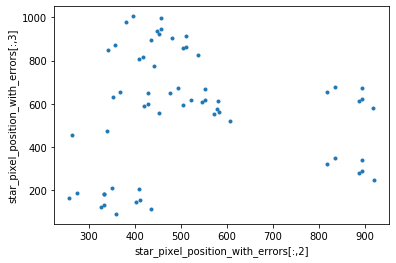

In [26]:
pyplot.plot(star_pixel_position_with_errors[:,2],
            star_pixel_position_with_errors[:,3], '.', ls='None')
pyplot.xlabel(r'star_pixel_position_with_errors[:,2]')
pyplot.ylabel(r'star_pixel_position_with_errors[:,3]')

pyplot.show()

1
2
3
4
5
6


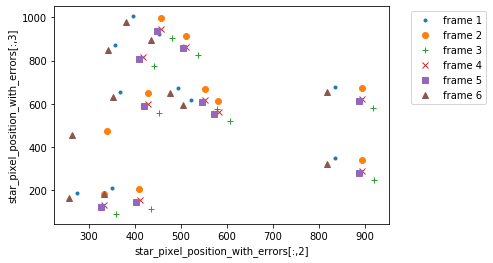

In [27]:
list_marker = ['.','o','+','x','s','^',]*10 # (It can handle up to 60 frames.)
for i_frame in range(1,7):# 6 frames
    print(i_frame)
    filter_tmp_plate_i = np.isclose(star_pixel_position_with_errors[:,0], i_frame)


    pyplot.plot(star_pixel_position_with_errors[filter_tmp_plate_i,2],
                star_pixel_position_with_errors[filter_tmp_plate_i,3],
                marker=list_marker[i_frame-1], ls='None', label='frame %d' % (i_frame))

pyplot.xlabel(r'star_pixel_position_with_errors[:,2]')
pyplot.ylabel(r'star_pixel_position_with_errors[:,3]')
pyplot.legend(bbox_to_anchor=(1.05, 1), )
pyplot.show()

# Possible location of the bug

## The function __overwrite_pixel_error_to_ecliptic is suspicious...

In [28]:

def __overwrite_pixel_error_to_ecliptic(star_pixel_position_with_errors):
    errors = star_pixel_position_with_errors[:, CenterCalculator.X_ERROR_INDEX:CenterCalculator.Y_ERROR_INDEX + 1]
    errors *= dpixel
    star_pixel_position_with_errors[:, CenterCalculator.X_ERROR_INDEX:CenterCalculator.Y_ERROR_INDEX + 1] = errors


If you want to check

- the behavior of the code with __overwrite_pixel_error_to_ecliptic enabled 
- the behavior of the code with __overwrite_pixel_error_to_ecliptic disabled

you need to set 

- TEST_overwrite = True
- TEST_overwrite = False

respectively.


In [29]:
TEST_overwrite = True # Default; This results in large values in c_vector.
#TEST_overwrite = False 



In [30]:
# retry:
star_pixel_position_with_errors = saved_star_pixel_position_with_errors *1.
psf_coefficient = saved_psf_coefficient*1.

if (TEST_overwrite):
    print('__overwrite_pixel_error_to_ecliptic is enabled.')
    __overwrite_pixel_error_to_ecliptic(star_pixel_position_with_errors=star_pixel_position_with_errors)
else:
    print('__overwrite_pixel_error_to_ecliptic is disabled.')


__overwrite_pixel_error_to_ecliptic is enabled.


In [21]:
star_pixel_position_with_errors

In [27]:
saved_star_pixel_position_with_errors

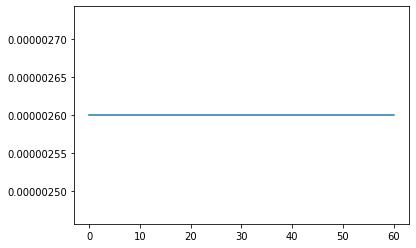

In [33]:
# error is multiplied by a factor.
pyplot.plot(star_pixel_position_with_errors[:,4]/saved_star_pixel_position_with_errors[:,4])

In [34]:
ecliptic_positions = large_frame_processor.convert_to_ecliptic(
star_pixel_position_with_errors=star_pixel_position_with_errors)


In [35]:
ecliptic_positions

array([[ 4.64547173, -0.1004345 ],
       [ 4.64561729, -0.10064775],
       [ 4.6453702 , -0.10077803],
       [ 4.64661346, -0.1012821 ],
       [ 4.64572395, -0.10129275],
       [ 4.64539919, -0.10134215],
       [ 4.64579672, -0.10143543],
       [ 4.64661341, -0.10214295],
       [ 4.64534933, -0.10249484],
       [ 4.64515202, -0.10255331],
       [ 4.64547206, -0.10043574],
       [ 4.6456176 , -0.10064895],
       [ 4.64661057, -0.10127915],
       [ 4.64572413, -0.10129111],
       [ 4.64539927, -0.1013403 ],
       [ 4.6457973 , -0.10143698],
       [ 4.64516762, -0.10179829],
       [ 4.64661348, -0.10214108],
       [ 4.64535051, -0.10249775],
       [ 4.64515235, -0.10255452],
       [ 4.64547218, -0.10043463],
       [ 4.64561772, -0.10064788],
       [ 4.64537062, -0.10077815],
       [ 4.64661162, -0.10128257],
       [ 4.64572437, -0.10129285],
       [ 4.64539957, -0.10134218],
       [ 4.64579718, -0.10143553],
       [ 4.64661376, -0.10214294],
       [ 4.64534977,

In [36]:
star_center_matrix = np.concatenate([
            star_pixel_position_with_errors[:, 0:MappedStarObservationsOnPlate.LONGITUDE_INDEX],
            ecliptic_positions,
            star_pixel_position_with_errors[:, MappedStarObservationsOnPlate.LONGITUDE_INDEX:]
], axis=1)

In [23]:
star_center_matrix

In [38]:
mapped_star_positions = MappedStarObservationsOnPlate(star_center_matrix=star_center_matrix)


In [39]:

# If not mapped yet, map blighter stars and known stars
if len(known_star_params) != 0 and known_star_params[0, 0] < 0:
    known_star_params = LargeFrameProcessor.map_known_stars(
                all_star_position=star_center_matrix,
                known_star_params=known_star_params,
                same_star_ecliptic_range=known_stars_ecliptic_neighborhood
    )
    logger.info('%d known stars are applied.', len(known_star_params))


2021-01-14 12:43:27,178  INFO  __main__ : 11 known stars are applied.


In [40]:
known_star_params

array([[ 7.00000000e+00,  4.64579883e+00, -1.01435491e-01,
         3.07744946e-05,  4.14946088e-05,  4.17334882e-05],
       [ 3.00000000e+00,  4.64537077e+00, -1.00776171e-01,
         2.94984693e-05,  4.74771806e-05,  9.01165615e-06],
       [ 4.00000000e+00,  4.64661284e+00, -1.01280098e-01,
         1.10035561e-06,  1.55943887e-06,  4.40834149e-05],
       [ 1.10000000e+01,  4.64516869e+00, -1.01797447e-01,
         4.35283201e-05,  4.68579008e-05,  1.95043346e-05],
       [ 5.00000000e+00,  4.64572467e+00, -1.01290897e-01,
         3.54672562e-05,  3.01499243e-05,  4.19518375e-05],
       [ 9.00000000e+00,  4.64535117e+00, -1.02495692e-01,
         4.92086085e-05,  3.39407283e-05,  3.39350733e-05],
       [ 1.00000000e+00,  4.64547259e+00, -1.00434281e-01,
         1.82441195e-05,  2.53214946e-05,  1.04189283e-05],
       [ 2.00000000e+00,  4.64561747e+00, -1.00647784e-01,
         3.89586797e-05,  9.54204166e-06,  2.68420093e-05],
       [ 8.00000000e+00,  4.64661394e+00, -1.021

In [41]:

def create_blighter_initial_parameters(star_positions, exp_term_number):
    """
        Create initial values for calculating distortion parameters using brighter stars.
        Plate parameters (c and d) are calculated from 3 stars in each plate.

        Parameters
        ----------
        star_positions: MappedStarObservationsOnPlate
            Star positions
        exp_term_number: int
            Plate parameter size (value assumes 1)

        Returns
        -------
        initial_parameters: DistortionParameters
            Initial values
    """

    # calculate coordinate average for each star
    lambda_vector, beta_vector = __average_for_each_star_id(
            unique_star_ids=star_positions.get_star_id_list(),
            star_index_list=star_positions.get_star_index_list(),
            lambda_list=star_positions.get_x_list(),
            beta_list=star_positions.get_y_list()
    )

    star_id_index = 1
    x_index = 2
    y_index = 3

    # calculate initial value of c_vector and d_vector for each plate
    c_vector = []
    d_vector = []
    for plate_index, plate_id in enumerate(np.unique(star_positions.get_plate_id_list())):
        same_plate_records = star_positions.get_records_by_plate_id(plate_id)
        if same_plate_records.shape[0] >= 3:
            # plate parameters can be calculated
            index1 = star_positions.get_star_id_mapping().get(int(same_plate_records[0, star_id_index]))
            index2 = star_positions.get_star_id_mapping().get(int(same_plate_records[1, star_id_index]))
            index3 = star_positions.get_star_id_mapping().get(int(same_plate_records[2, star_id_index]))
            parameter_matrix = np.array([
                    1.0,
                    float(lambda_vector[index1]),
                    float(beta_vector[index1]),
                    1.0,
                    float(lambda_vector[index2]),
                    float(beta_vector[index2]),
                    1.0,
                    float(lambda_vector[index3]),
                    float(beta_vector[index3])
            ]).reshape(3, 3)
            parameter_matrix = np.linalg.pinv(parameter_matrix)
            c_vector_in_plate = np.matmul(parameter_matrix, np.array(same_plate_records[0:3, x_index]))
            d_vector_in_plate = np.matmul(parameter_matrix, np.array(same_plate_records[0:3, y_index]))
        else:
            # plate parameters cannot be calculated
            logger.debug('Stars is too few to decide initial plate parameter. plate_id=%d, stars=%d',
                             plate_id, same_plate_records.shape[0])
            c_vector_in_plate = np.random.rand(3) - 0.5
            d_vector_in_plate = np.random.rand(3) - 0.5
        c_vector.extend(c_vector_in_plate.tolist())
        d_vector.extend(d_vector_in_plate.tolist())

    c_vector = np.array(c_vector)
    d_vector = np.array(d_vector)
    c_common_vector = np.zeros(int((exp_term_number + 1) * (exp_term_number + 2) / 2 - 3))
    d_common_vector = np.zeros(int((exp_term_number + 1) * (exp_term_number + 2) / 2 - 3))

    return DistortionParameters(lambda_vector, beta_vector, c_vector, d_vector, c_common_vector, d_common_vector)


In [42]:
def __average_for_each_star_id(unique_star_ids, star_index_list, lambda_list, beta_list):
    """
        Calculate average of lambda and beta value for each star.

        Parameters
        ----------
        unique_star_ids: np.array (1 order)
            Unique star ID list (ordered)

        Returns
        -------
        lambda_vector: np.array (1 order)
            Average value of lambda (array length is same to star ids)
        beta_vector: np.array (1 order)
            Average value of beta (array length is same to star ids)
    """
    onehot_star_id = np.eye(len(unique_star_ids))[star_index_list]
    onehot_star_id[onehot_star_id == 0] = np.nan
    onehot_x = lambda_list.reshape(-1, 1) * onehot_star_id
    onehot_y = beta_list.reshape(-1, 1) * onehot_star_id
    lambda_vector = np.nanmean(onehot_x, axis=0)
    beta_vector = np.nanmean(onehot_y, axis=0)
    return lambda_vector, beta_vector

In [43]:
initial_parameters_tmp = create_blighter_initial_parameters(star_positions=mapped_star_positions,
                                                                       exp_term_number=1)

In [44]:
initial_parameters_tmp.lambda_vector

array([4.64547169, 4.64561683, 4.64537006, 4.64661208, 4.64572387,
       4.64539908, 4.64579721, 4.64661329, 4.64535019, 4.64515198,
       4.64516773])

In [45]:
initial_parameters_tmp.beta_vector

array([-0.10043513, -0.1006484 , -0.10077796, -0.10128144, -0.10129243,
       -0.10134174, -0.10143614, -0.10214253, -0.10249675, -0.10255393,
       -0.10179848])

In [46]:
initial_parameters_tmp.c_vector

array([-8.04338752e-03,  1.00171450e+00, -7.84395470e-04,  2.81033231e-02,
        9.93818302e-01, -6.11286914e-03, -8.17860109e-03,  1.00174516e+00,
       -7.16616772e-04, -7.96298479e-03,  1.00169364e+00, -9.34143314e-04,
       -8.28508372e-03,  1.00176678e+00, -7.71329298e-04,  4.65759722e-02,
        9.90039827e-01,  3.04355648e-03])

In [47]:
initial_parameters_tmp.d_vector

array([-0.00984114,  0.00214864,  1.00139087, -0.02163698,  0.00472084,
        1.00292862, -0.0096778 ,  0.00211332,  1.00138467, -0.01061274,
        0.00231277,  1.00130317, -0.00999036,  0.00217976,  1.0013484 ,
        0.03316956, -0.00722916,  0.99589504])

In [48]:
initial_parameters_tmp.c_common_vector

array([], dtype=float64)

In [49]:
initial_parameters_tmp.d_common_vector

array([], dtype=float64)

In [50]:
# calculate distortion of plates by using brighter stars
distortion_calculator = DistortionCalculator(mapped_star_positions)
plate_parameters, plate_parameter_errors = distortion_calculator.calculate(
            known_star_params=known_star_params,
            max_iteration=position_iteration,
            initial_parameters=create_blighter_initial_parameters(star_positions=mapped_star_positions,
                                                                       exp_term_number=1)
        )

2021-01-14 12:43:36,241  INFO  image.distortion : Preparing least square calculation for star position parameters... (number of stars = 11, number of plates = 6)
2021-01-14 12:43:36,242  DEBUG  image.distortion : Known star indices: [ 6.  2.  3. 10.  4.  8.  0.  1.  7.  5.  9.]
2021-01-14 12:43:36,244  INFO  image.distortion : Start solving distortion parameters.
2021-01-14 12:43:36,285  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 475581.436723)
2021-01-14 12:43:36,319  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 2315396.144476)
2021-01-14 12:43:36,354  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 2751730.805753)
2021-01-14 12:43:36,386  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 1201157985.661090)
2021-01-14 12:43:36,417  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm 

star_position_restraint_return_size 22


2021-01-14 12:43:36,452  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 34224617351673.652344)
2021-01-14 12:43:36,486  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-01-14 12:43:36,488  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 40682735.310314)
2021-01-14 12:43:36,522  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-01-14 12:43:36,523  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 10558.259445)
2021-01-14 12:43:36,555  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-01-14 12:43:36,557  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 9, norm = 0.003302)
2021-01-14 12:43:36,590  INFO  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-

In [52]:
plate_parameters.c_vector

array([ 1.33554721e+13,  5.61238477e+11, -2.77645903e+12,  1.06379895e+13,
        6.15913011e+12, -2.39240496e+12,  1.37831633e+13,  2.03161151e+12,
       -2.86519185e+12,  1.30856313e+13, -8.79019137e+11, -2.82728653e+12,
        1.57931704e+13, -1.45876022e+12, -3.41544896e+12,  1.20482360e+13,
        2.43275484e+12, -2.61639863e+12])

## Short summary

- When TEST_overwrite = True (__overwrite_pixel_error_to_ecliptic is enabled), you will probably get very large plate_parameters.c_vector

- When TEST_overwrite = False (__overwrite_pixel_error_to_ecliptic is disabled), this problem seems to disappear. 

I am not sure if __overwrite_pixel_error_to_ecliptic is working as expected, but just in case I share this information. 
Hope it helps somebody!

